In [10]:
import matplotlib.pyplot as plt
import json

import json
import matplotlib.pyplot as plt
import os
import glob

def divide_non_none_elements(input_list, n):
    return [x / n for x in input_list if x is not None]

def check_contains_all_substrings(string, substrings):
    return all(substring in string for substring in substrings)

def check_contains_any_substrings(string, substrings):
    return any(substring in string for substring in substrings)


def get_data(directory, e, tags = None):
    file_list = glob.glob(f'{directory}/**/*.jsonl', recursive=True)

    dirlist  = os.listdir(directory)
    lmbdas = set([])
    for d in dirlist:
        if not 'lmbda=' in d:
            continue
        start = d.find('lmbda=') + len('lmbda=')
        end = d.find('-encoder', start)
        lmbda_value = float(d[start:end])
        # print(lmbda_value)
        lmbdas.add(lmbda_value)

    # print(lmbdas)
    lmbdas = sorted(lmbdas)
    data_dict = {}
    for l in lmbdas: 
        data_dict[l] = []
        
    for l in lmbdas:
        for file_path in file_list:
            if (f'lmbda={l}' in file_path):
                # if type(tags) == list and check_contains_any_substrings(file_path, tags):
                    with open(file_path, 'r') as f:
                        for line in f:
                            data_dict[l].append(json.loads(line))

    def get_rate_mse(e, data):
        for entry in data:
            if entry['epoch'] == e:
                return entry['val_rate'], entry['val_mse'], entry['rate'], entry['mse']
        return None, None, None, None  # 해당 epoch이 없을 경우
        
    data = [get_rate_mse(e, data_dict[l]) for l in lmbdas]
    # sorted_data = sorted(data, key=lambda x: x[1])
    return data, lmbdas, data_dict

def get_RD_plot_data(directory, e, label):
    data, lmbdas, data_dict = get_data(directory, e)
    
    val_rate = [entry[0] for entry in data]
    val_mse = [entry[1] for entry in data]
    val_rate = divide_non_none_elements(val_rate, 1)
    val_mse = divide_non_none_elements(val_mse, 1)
    rate = [entry[2] for entry in data]
    mse = [entry[3] for entry in data]
    rate = divide_non_none_elements(rate, 1)
    mse = divide_non_none_elements(mse, 1)
    
    return val_mse, val_rate, mse, rate, label


In [14]:
directories = []

# title =  'Llama3-8B, MLP'
# pairs = [(16, '5e-5'),
#          (64, '5e-6'),
#          (128, '1e-4'), 
#          (256, '1e-4'), 
#          (512, '1e-4'), 
#          (1024, '5e-5'),
#          (4096, '1e-5')]

# for dim in [16, 32, 64, 128, 256, 1024]:
#     for lr in ['1e-4', '5e-5', '1e-5', '5e-6']:
#         direct = f'/home/jgryu/Weight_compression/RD-sandwich/checkpoints_v3/llama3_mlp_in/llama3-8B_d{dim}_b1024_e150_lr{lr}_normalize'
#         directories.append((direct, f'size{dim}, lr{lr}'))

for dim in [16, 32, 64, 128, 256, 1024]:
    directories.append((f'/home/jgryu/Weight_compression/RD-sandwich/checkpoints_v2/llama3_mlp/llama3-8B_d{dim}_b1024_e150_lr1e-4_normalize', f'Out, size{dim}, lr{5e-6}'))
    directories.append((f'/home/jgryu/Weight_compression/RD-sandwich/checkpoints_v3/llama3_mlp_in/llama3-8B_d{dim}_b1024_e150_lr5e-6_normalize', f'In, size{dim}, lr{5e-6}'))
directories.append(('/home/jgryu/Weight_compression/RD-sandwich/checkpoints_v2/llama3_mlp/llama3-8B_d1024_b1024_e150_lr5e-5_normalize_0', 'Out, 1024, 5e-5'))

plot_data = {}
for directory, label, in directories:
    try:
        val_mse, val_rate, mse, rate, label = get_RD_plot_data(directory=directory, e=149, label=label)
        plot_data[label] = {'val_mse': val_mse, 'val_rate':val_rate, 'mse': mse, 'rate': rate}
    except Exception as err:
        print(f"예외 발생: {err}")
        continue

예외 발생: [Errno 2] No such file or directory: '/home/jgryu/Weight_compression/RD-sandwich/checkpoints_v2/llama3_mlp/llama3-8B_d32_b1024_e150_lr1e-4_normalize'
예외 발생: [Errno 2] No such file or directory: '/home/jgryu/Weight_compression/RD-sandwich/checkpoints_v2/llama3_mlp/llama3-8B_d1024_b1024_e150_lr1e-4_normalize'


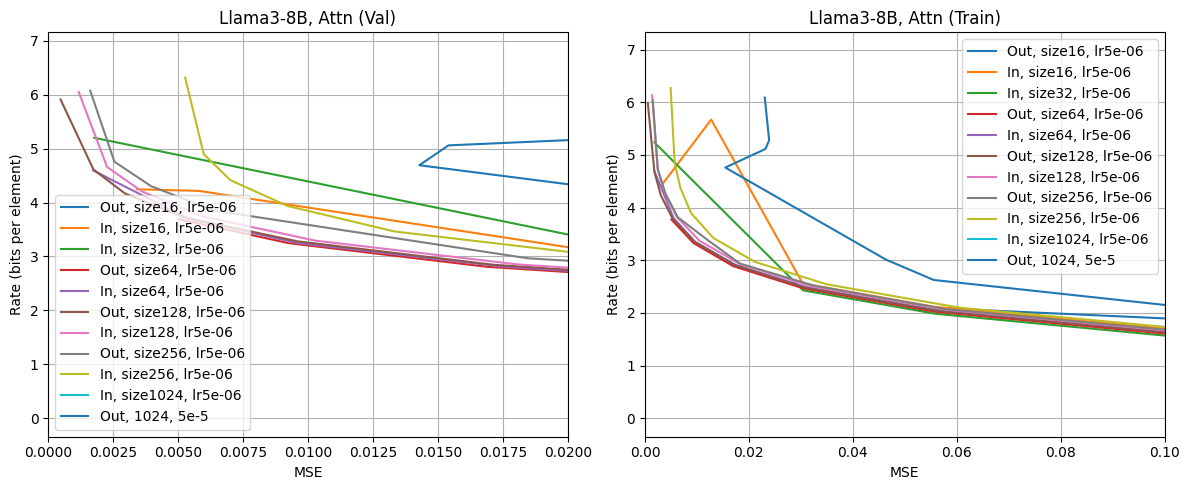

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for l, v in plot_data.items():
    plt.plot(v['val_mse'], v['val_rate'], linestyle='-', label=l)

# Training subplot
plt.subplot(1, 2, 2)
for l, v in plot_data.items():
    plt.plot(v['mse'], v['rate'], linestyle='-', label=l)

# Validation subplot 설정
plt.subplot(1, 2, 1)
plt.title('Llama3-8B, Attn (Val)')
plt.xlabel('MSE')
plt.ylabel('Rate (bits per element)')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.02)
# Training subplot 설정
plt.subplot(1, 2, 2)
plt.title('Llama3-8B, Attn (Train)')
plt.xlabel('MSE')
plt.ylabel('Rate (bits per element)')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)

# 서브플롯 전체 보여주기
plt.tight_layout()
plt.show()